In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = 'retina'

In [2]:
import nawrapper as nw
import pymaster as nmt
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap

In [3]:
! echo $OMP_NUM_THREADS

40


# File Loading

We specify the filepaths here. In the first cell, we load in a map which has the WCS and shape information, with which we will crop all other maps to fit. When we take power spectra, we want all of the maps involved to have the same shape and WCS!

In [4]:
data_root = '/tigress/zequnl/cmb/data/from_choi/'
apopath = f'{data_root}/apo_mask/deep56_c7v5_car_190220_rect_master_apo_w0.fits'
steve_apo = enmap.read_map(apopath)
shape, wcs = steve_apo.shape, steve_apo.wcs

Next, we load in the maps and masks. In this example, the same mask is used to speed up the spectra calculation, but in general each map will have a different mask. We also apply the k-space filter at this step, with $|k_x| < 90$ and $|k_y| < 50$.

### Legacy Support
There is an important flag here, `legacy_steve = True`. At the time of this writing, Steve's code applies a slightly incorrect k-space filter, and offsets the maps by `(-1,-1)` in `WCS.CRPIX`.

In [5]:
mapname_head = f"{data_root}/maps/ACTPol_148_D56_pa1_f150_s14_4way_split"
mask_file =  f"{data_root}/window/deep56_s14_pa1_f150_c7v5_car_190220_rect_w0_cl0.00nK_pt1.00_nt0.0_T.fits"
mask_pol_file =  f"{data_root}/window/deep56_s14_pa1_f150_c7v5_car_190220_rect_w0_cl0.00nK_pt1.00_nt0.0.fits"
beam_filename = f"{data_root}/beam/beam_tform_160201_s14_pa1_f150_jitter_CMB_deep56.txt"

# loop over splits and generate 
nsplits = 4
beam = nw.read_beam(beam_filename)

# for this example, we make the maps conform to the same WCS and shape
mask = enmap.read_map(mask_file)
mask = enmap.extract(mask, shape, wcs)
apo = nw.rectangular_apodization(shape, wcs, 40)

In [ ]:
namap_list = []
for i in range(nsplits):
    
    map_I = enmap.read_map(f"{mapname_head}{i}_srcadd_I.fits")
    nw.legacy_steve_shift(map_I)  # adjust WCS to reproduce steve spectra
    map_I = enmap.extract(map_I, shape, wcs)
    map_I = nw.kfilter_map(
        map_I, apo, kx_cut=90, ky_cut=50,
        unpixwin=True, legacy_steve=True)
    
    split_namap = nw.namap_car(
        maps=map_I,
        masks=mask, 
        beams=beam,
        sub_wcs=wcs, sub_shape=shape)
    namap_list.append(split_namap)

Assuming the same mask for both I and QU.
Assuming the same beams for both I and QU.
Creating a car namap. temperature: True, polarization: False
Computing spherical harmonics.

Assuming the same mask for both I and QU.
Assuming the same beams for both I and QU.
Creating a car namap. temperature: True, polarization: False
Computing spherical harmonics.



In [ ]:
m0 = enmap.read_map(f"{mapname_head}{0}_srcadd_I.fits")
nw.legacy_steve_shift(m0)
apo = nw.rectangular_apodization(shape, wcs, 40)
em0 = enmap.extract(m0, shape, wcs)
em0 = nw.kfilter_map(em0, apo, kx_cut=90, ky_cut=50, 
                     unpixwin=True, legacy_steve=True)

In [ ]:
print(np.std(namap_list[0].map_I))
print(np.std(em0))

In [ ]:
from pixell import enplot
def eshow(m, **kwargs): 
    pl=enplot.plot(m,downgrade=8,ticks=5, **kwargs)
    enplot.show(pl)

In [ ]:
eshow(em0 - namap_list[0].map_I)

# Compute Mode Coupling Matrix

In [ ]:
binfile = f'{data_root}/binning/BIN_ACTPOL_50_4_SC_low_ell'
bins = nw.read_bins(binfile, is_Dell=True)
mc = nw.mode_coupling(
    namap_list[0], namap_list[1], bins,
    mcm_dir='/tigress/zequnl/cmb/data/mcm/example_steve', 
    overwrite=False
)

In [ ]:
# Cb01 = nw.compute_spectra(namap_list[0], namap_list[1], mc=mc)
# np.save('test.npy', Cb01['TT'])

Cb01 = nw.compute_spectra(namap_list[0], namap_list[1], mc=mc)
t01 = np.load('test.npy')
plt.plot(Cb01['TT'] / t01)

# Computing Spectra

Next, we apply the mode coupling matrix to each pair of `namap` objects. We will reuse the mode coupling object we computed, since all the masks are the same in this toy example. We take a flat mean of the 4 choose 2 = 6 cross spectra, and also compute the standard error.

In [7]:
spec_dict = {}
TT_cross_spectra = []
# TE_cross_spectra = []
# EE_cross_spectra = []
# we reuse the mode coupling matrix `mc` from earlier
for i in range(len(namap_list)):
    for j in range(len(namap_list)):
        if i >= j:
            Cb = nw.compute_spectra(
                namap_list[i], namap_list[j], mc=mc)
            for clXY in Cb:
                spec_dict[f"{clXY},{i},{j}"] = Cb[clXY]
            if i > j:
                TT_cross_spectra += [Cb['TT']]
#                 TE_cross_spectra += [Cb['TE']]
#                 TE_cross_spectra += [Cb['ET']]
#                 EE_cross_spectra += [Cb['EE']]

In [8]:
mean_Cltt = np.sum(TT_cross_spectra, axis=0) / len(TT_cross_spectra)
se_Cltt = np.std(TT_cross_spectra, axis=0)/np.sqrt(len(TT_cross_spectra))

/home/zequnl/.conda/envs/ps/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.
/home/zequnl/.conda/envs/ps/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/zequnl/.conda/envs/ps/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/zequnl/.conda/envs/ps/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Check Our Results

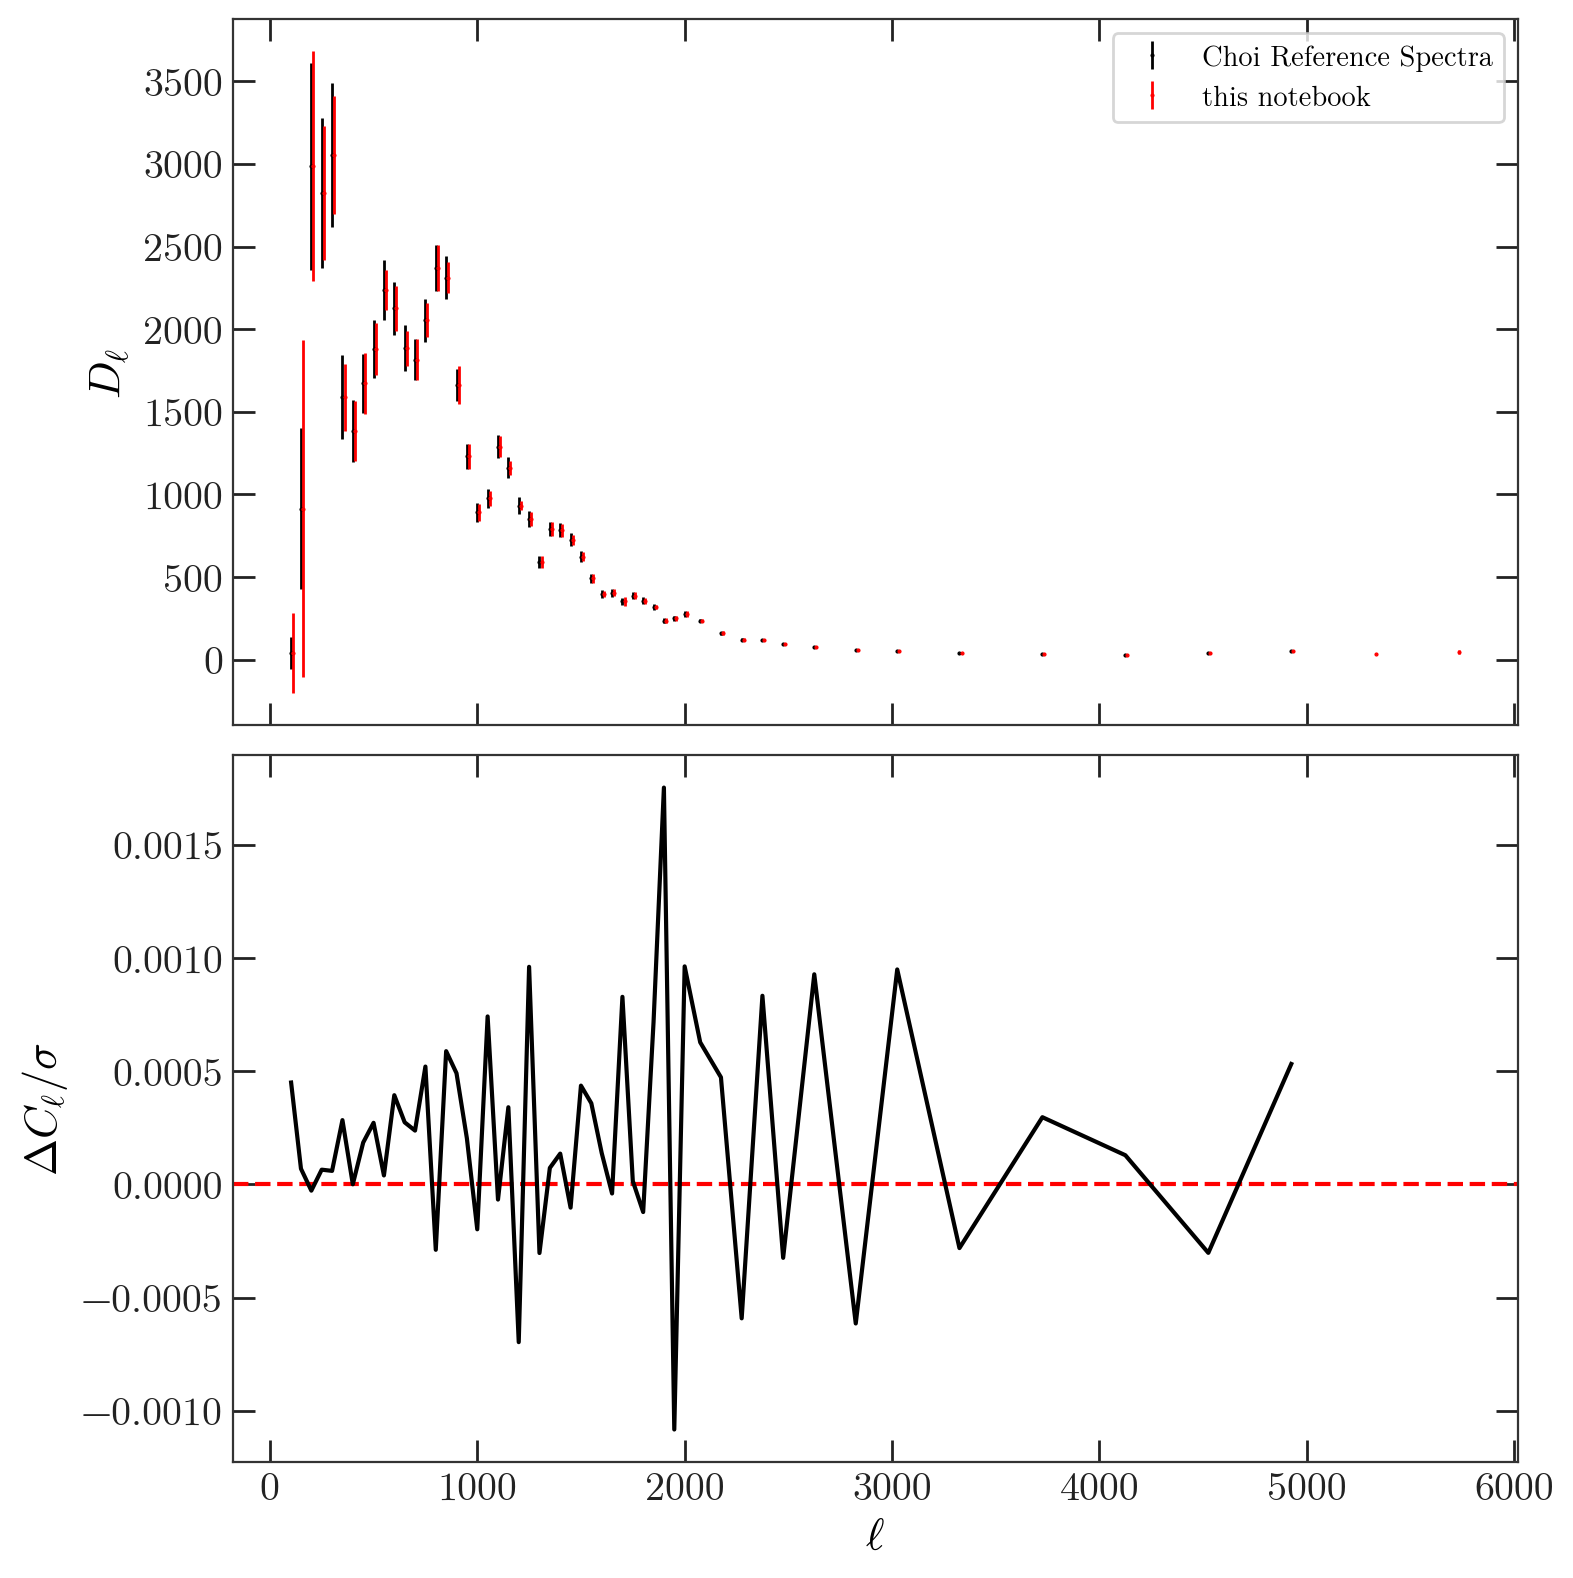

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(8,8), sharex=True)

# plot steve spectra
specfile = f"{data_root}/ps/deep56_s14_pa1_f150_c7v5_car_190220_rect_window0_TT_lmax7925_fsky0.01081284_output.txt"
choi_ell, choi_dl, choi_delta_dl, _ = np.loadtxt(specfile, unpack=True)[:,2:54]
axes[0].errorbar( choi_ell, choi_dl, yerr=choi_delta_dl, fmt='k.', 
                 lw=1, ms=1, label="Choi Reference Spectra" )
# plot our spectra
lb = mc.lb[1:-3]
notebook_dl = mean_Cltt[1:-3] 
axes[0].errorbar(lb + 10, notebook_dl, # we slightly offset to not overlap
                 fmt='r.', 
                 yerr=(notebook_dl / np.sqrt(2 * lb + 1) + se_Cltt[1:-3]),
                 lw=1, ms=1, label="this notebook")
axes[0].set_ylabel(r"$D_{\ell}$")
axes[0].legend(frameon=True)

# plot ratio
axes[1].axhline(0.0, ls='dashed', color='red')
axes[1].plot( lb[:-2], (notebook_dl[:-2] - choi_dl) / choi_delta_dl )
axes[1].set_ylabel('$ \Delta C_{\ell} / \sigma$')
axes[1].set_xlabel(r'$\ell$')
plt.tight_layout()

In [10]:
## We can also computed the polarization power spectra, so here we plot them.
## 
# fig, axes = plt.subplots(2,1, sharex=True, figsize=(8,8))
# axes[0].set_title("TE")
# mean_Clte = np.sum(TE_cross_spectra, axis=0) / len(TE_cross_spectra)
# axes[0].plot(mc.lb, mean_Clte)

# axes[1].set_title("EE")
# mean_Clee = np.sum(EE_cross_spectra, axis=0) / len(EE_cross_spectra)
# axes[1].plot(mc.lb, mean_Clee)

# Bandpower Windows

In [11]:
bpw = mc.w00.get_bandpower_windows()

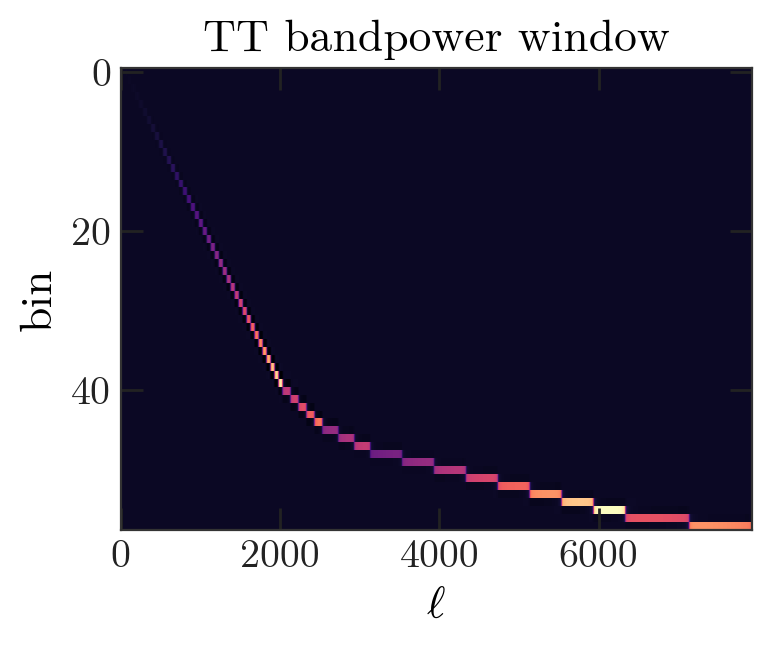

In [25]:
plt.imshow(bpw.reshape(58,7926), aspect=100)
plt.ylabel('bin')
plt.xlabel(r'$\ell$')
plt.title('TT bandpower window');